In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
import scipy.io
import os
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape,LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.initializers import RandomNormal

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d tthien/shanghaitech-with-people-density-map

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 4.77G/4.79G [01:09<00:00, 83.3MB/s]
100% 4.79G/4.79G [01:09<00:00, 74.3MB/s]


In [ ]:
!unzip "/content/shanghaitech-with-people-density-map.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_199.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_2.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_20.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_200.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_201.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_202.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_203.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_204.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_205.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_206.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/images/IMG_207.jpg  
  inflating: /content/dataset/ShanghaiTech/part_B/test_data/i

# DATA PREPARATION

In [ ]:
IN_X,IN_Y=768,1024
OUT_X,OUT_Y=96,128
SUBSAMPLING_FACTOR=IN_X//OUT_X

In [ ]:
def gauss_distribution(x,u=0,sigma=10):
    return np.expand_dims(1/(np.sqrt(2*np.pi*(sigma**2)))*np.exp(-(0.5)*(((x-u)/sigma)**2)),axis=0)

In [ ]:
def get_density_map_gaussian(im,points,gaussian_radius=4):
    density_map=np.zeros((OUT_X,OUT_Y))
    w,h=OUT_Y,OUT_X
    num_gt=len(points)

    for point in points:
        point=np.round(point).astype(int)
        point[0],point[1]=min(h-1,point[1]),min(w-1,point[0])
        x=np.linspace(-gaussian_radius,gaussian_radius,(gaussian_radius*2)+1)
        gaussian_map=np.multiply(gauss_distribution(x),gauss_distribution(x).T)
        gaussian_map/=np.sum(gaussian_map)

        x_left,x_right,y_up,y_down=0,gaussian_map.shape[1],0,gaussian_map.shape[0]
        if point[1]<gaussian_radius:
            x_left=gaussian_radius-point[1]
        if point[0]<gaussian_radius:
            y_up=gaussian_radius-point[0]
        if point[1]+gaussian_radius>=w:
            x_right=gaussian_map.shape[1]-(gaussian_radius+point[1]-w)-1
        if point[0]+gaussian_radius>=h:
            y_down=gaussian_map.shape[0]-(gaussian_radius+point[0]-h)-1
        density_map[
            max(0,point[0]-gaussian_radius):min(density_map.shape[0],point[0]+gaussian_radius+1),
            max(0,point[1]-gaussian_radius):min(density_map.shape[1],point[1]+gaussian_radius+1),
        ]+=gaussian_map[y_up:y_down,x_left:x_right]
    density_map/=np.sum(density_map/len(points))
    return density_map

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__ (self, images, maps, batch_size,SUBSAMPLING_FACTOR=8):

        self.images = images
        self.maps = maps
        self.batch_size = batch_size
        self.train_image_list=os.listdir(images)
        self.SUBSAMPLING_FACTOR=SUBSAMPLING_FACTOR

    def __len__(self):
        return int(np.floor(len(self.train_image_list)/self.batch_size))

    def __getitem__(self, idx):
        x,y = self.__data_generation(idx)
        return x,y

    def __data_generation(self, idx):
        x = []
        y = []

        for j in range(idx*self.batch_size, (idx+1)*self.batch_size):

            im_array=img_to_array(load_img(self.images+os.listdir(self.images)[j],target_size=(IN_X,IN_Y)))
            im_array/=255.
            im_array[:,:,0]=(im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
            im_array[:,:,1]=(im_array[:,:,1]-np.mean(im_array[:,:,1]))/np.std(im_array[:,:,1])
            im_array[:,:,2]=(im_array[:,:,2]-np.mean(im_array[:,:,2]))/np.std(im_array[:,:,2])
            x.append(im_array)

            mat=scipy.io.loadmat(self.maps+os.listdir(self.maps)[j])
            points=mat['image_info'][0][0][0][0][0]
            points/=self.SUBSAMPLING_FACTOR

            density_map_present = get_density_map_gaussian(im_array, points)
            y.append(density_map_present)

        return tf.convert_to_tensor(x),tf.convert_to_tensor(y)

In [ ]:
train_images='/content/dataset/ShanghaiTech/part_A/train_data/images/'
train_maps='/content/dataset/ShanghaiTech/part_A/train_data/ground-truth/'
val_images='/content/dataset/ShanghaiTech/part_A/test_data/images/'
val_maps='/content/dataset/ShanghaiTech/part_A/test_data/ground-truth/'

LR=1e-4
BATCH_SIZE=1
EPOCH=1000

In [ ]:
INPUT_DIM=None

In [ ]:
train_gen = DataGenerator(train_images, train_maps,BATCH_SIZE)
#val_gen = DataGenerator(val_images, val_maps,BATCH_SIZE,INPUT_DIM)

# MODELING

In [ ]:
def get_base_model():
    base_model = VGG16(
        weights='imagenet',
        input_shape=(INPUT_DIM, INPUT_DIM, 3),
        include_top=False,
    )
    # Extracting the output tensor of the "block4_conv3" layer
    block4_conv3 = base_model.get_layer("block4_conv3").output
    return Model(
        inputs=base_model.inputs,
        outputs=block4_conv3
    )

get_base_model().summary()


Model: "model_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_105 (InputLayer)      [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0  

In [ ]:
inputs=tf.keras.Input(shape=(IN_X,IN_Y,3))
x=get_base_model()(inputs)
init=RandomNormal(stddev = 0.01)

x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(512, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(256, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(128, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(64, (3,3), activation = 'relu', dilation_rate=2,kernel_initializer=init,padding='same')(x)
x=Conv2D(1, (1,1), activation = 'relu', dilation_rate=1,kernel_initializer=init,padding='same')(x)

out=Reshape((96,128))(x)
#out = x[..., 0]
model=tf.keras.Model(inputs=inputs,outputs=out)
model.summary()



Model: "model_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_106 (InputLayer)      [(None, 768, 1024, 3)]    0         
                                                                 
 model_75 (Functional)       (None, None, None, 512)   7635264   
                                                                 
 conv2d_119 (Conv2D)         (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_120 (Conv2D)         (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_121 (Conv2D)         (None, 96, 128, 512)      2359808   
                                                                 
 conv2d_122 (Conv2D)         (None, 96, 128, 256)      1179904   
                                                                 
 conv2d_123 (Conv2D)         (None, 96, 128, 128)      295

In [ ]:
model.compile(
    loss='mse',
    optimizer = Adam(learning_rate = LR),
    metrics='accuracy',
    #run_eagerly = True,
)

In [ ]:
checkpoint_filepath='/content/drive/MyDrive/Bang/people_counting_VGG16.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

In [ ]:
history = model.fit(
    train_gen,
    verbose=1,
    shuffle=True,
    epochs=EPOCH,
    callbacks=[callback])

Epoch 1/1000
300/300 [==============================] - 419s 1s/step - loss: 0.0123 - accuracy: 0.0052
Epoch 2/1000
300/300 [==============================] - 418s 1s/step - loss: 0.0117 - accuracy: 0.0306
Epoch 3/1000
300/300 [==============================] - 407s 1s/step - loss: 0.0114 - accuracy: 0.1020
Epoch 4/1000
300/300 [==============================] - 401s 1s/step - loss: 0.0115 - accuracy: 0.1166
Epoch 5/1000
300/300 [==============================] - 397s 1s/step - loss: 0.0113 - accuracy: 0.1207
Epoch 6/1000
300/300 [==============================] - 396s 1s/step - loss: 0.0114 - accuracy: 0.1219
Epoch 7/1000
300/300 [==============================] - 397s 1s/step - loss: 0.0113 - accuracy: 0.1135
Epoch 8/1000
300/300 [==============================] - 403s 1s/step - loss: 0.0112 - accuracy: 0.0959
Epoch 9/1000
300/300 [==============================] - 408s 1s/step - loss: 0.0112 - accuracy: 0.1036
Epoch 10/1000
300/300 [==============================] - 395s 1s/step - l

KeyboardInterrupt: ignored

# TESTING

1/1 [==============================] - 0s 78ms/step
The actual number of people is = 920
The predicted number of people is = 452.29102


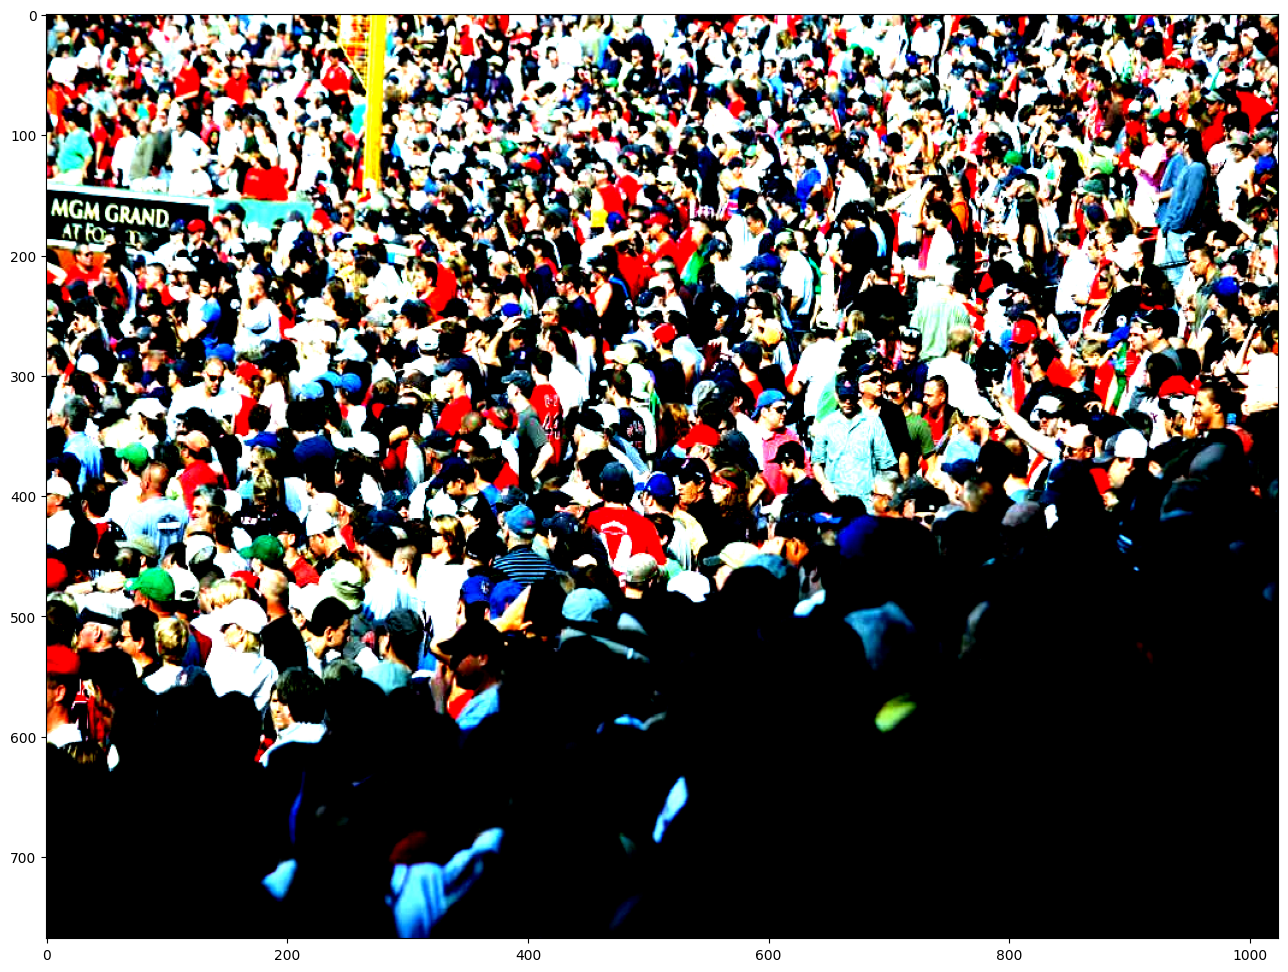

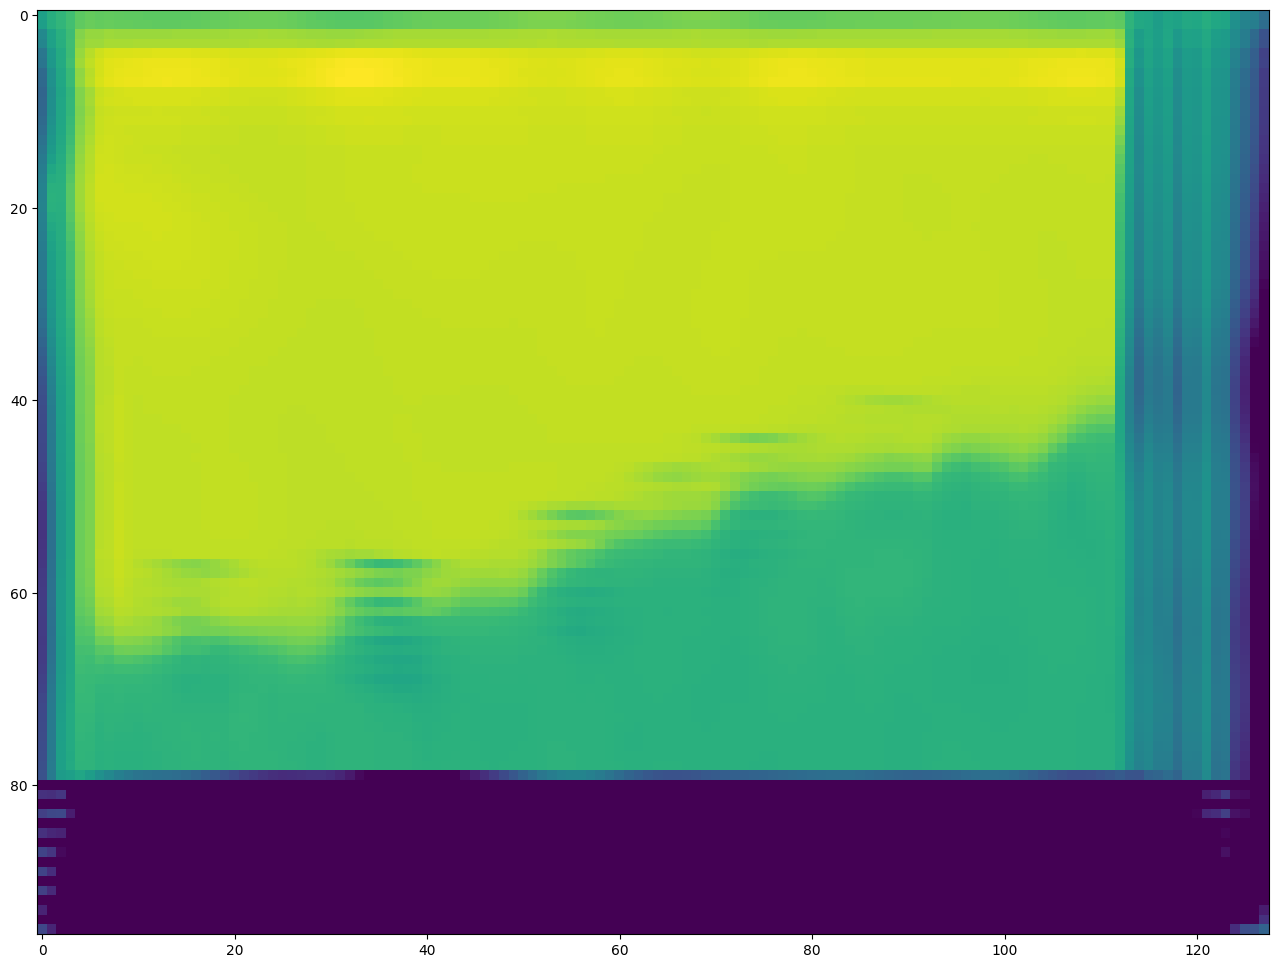

In [ ]:
IN ='IMG_10'

im_array = img_to_array(load_img(train_images + IN + '.jpg', target_size=(IN_X, IN_Y)))
im_array /= 255.0
im_array[:, :, 0] = (im_array[:, :, 0] - np.mean(im_array[:, :, 0])) / np.std(im_array[:, :, 0])
im_array[:, :, 1] = (im_array[:, :, 1] - np.mean(im_array[:, :, 1])) / np.std(im_array[:, :, 1])
im_array[:, :, 2] = (im_array[:, :, 2] - np.mean(im_array[:, :, 2])) / np.std(im_array[:, :, 2])

plt.figure(figsize=(20, 12))
plt.imshow(im_array)  # Corrected: plt.imhow -> plt.imshow

output = model.predict(tf.expand_dims(im_array, axis=0))
output = np.reshape(output, (OUT_X, OUT_Y))

n_people = np.sum(output)
mat = scipy.io.loadmat(train_maps + 'GT_' + IN + '.mat')
points = mat['image_info'][0][0][0][0][0]
points /= SUBSAMPLING_FACTOR

num_gt = np.squeeze(points).shape[0]
print("The actual number of people is =", num_gt)
print("The predicted number of people is =", n_people)

plt.figure(figsize=(20, 12))
plt.imshow(output)
plt.show()  # Added to display the plot
